### End to End Walkthrough of a Machine Learning Project

#### Main Steps
1. Look at the big picture
2. Retreive the data
3. Exploratory analysis of data
4. Data preparation
5. Select a ML model and train it
6. Tune the model (hyperparameters)
7. Present Solution
8. Launch, monitor, maintain the system

Plenty of places to get real-world datasets from:

- UC Irvine Machine Learning Repository
- Kaggle
- AWS datasets
- http://dataportals.org/
- http://opendatamonitor.eu/
- http://quandl.com/
- Wiki list of ML datasets

For this example, the dataset will be the California Housing Prices dataset from the StatLib repository. The objective is to create a ML model to predict the median housing price in any district.

#### Select a performance measure

For the project, need to select a performance measure. For regression models, the standard is the Root Mean Sqaure Error (the standard deviation in the errors of the predictions of the model).

$$RMSE(\boldsymbol{X},h)=\sqrt{\frac{1}{m}\sum_{i=1}^{m}(h(x^i)-y^i)}$$

If there are many outliers in your data, it may be better to use the Mean Absolute Error MAE (Average Absolute Deviation)

$$MSE(\boldsymbol{X},h)=\sqrt{\frac{1}{m}\sum_{i=1}^{m}|h(x^i)-y^i|}$$

The RMSE is known as the Euclidean norm/distance
THe MSE is known as the Manhatten norm/distance

In [1]:
#Getting the data
import os
import tarfile
from six.moves import urllib

DOWNLOAD_PATH = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
DATA_PATH = "datasets/housing"
TARGET_URL = DOWNLOAD_PATH + DATA_PATH + "/housing.tgz"

def get_housing_data(target_url=TARGET_URL, data_path=DATA_PATH):
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
    tgz_path = os.path.join(data_path, "housing.tgz")
    urllib.request.urlretrieve(target_url, tgz_path)
    data_tgz = tarfile.open(tgz_path)
    data_tgz.extractall(path=data_path)
    data_tgz.close()

get_housing_data()

In [2]:
#Load the data into pandas
import pandas as pd

def load_data(path=DATA_PATH):
    csv_path = os.path.join(path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


We can see from the data, each row represents one district. There are 10 features. The .info() method from pandas gives us a brief overview of the dataset.

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Within the dataset there are 20,640 instances. We can also see that the total_bedrooms column has 207 missing values. 

All features are numerical, except for ocean_proximity. We can check what is included in this feature using the .value_counts() method.

In [4]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

To look deeper into numerical features, we can use the describe() method.

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


A more visual way to insepct the data is to plot a histogram for each feature with the hist() method or a pairplot in seaborn (with 10 features though, this is a bit much).

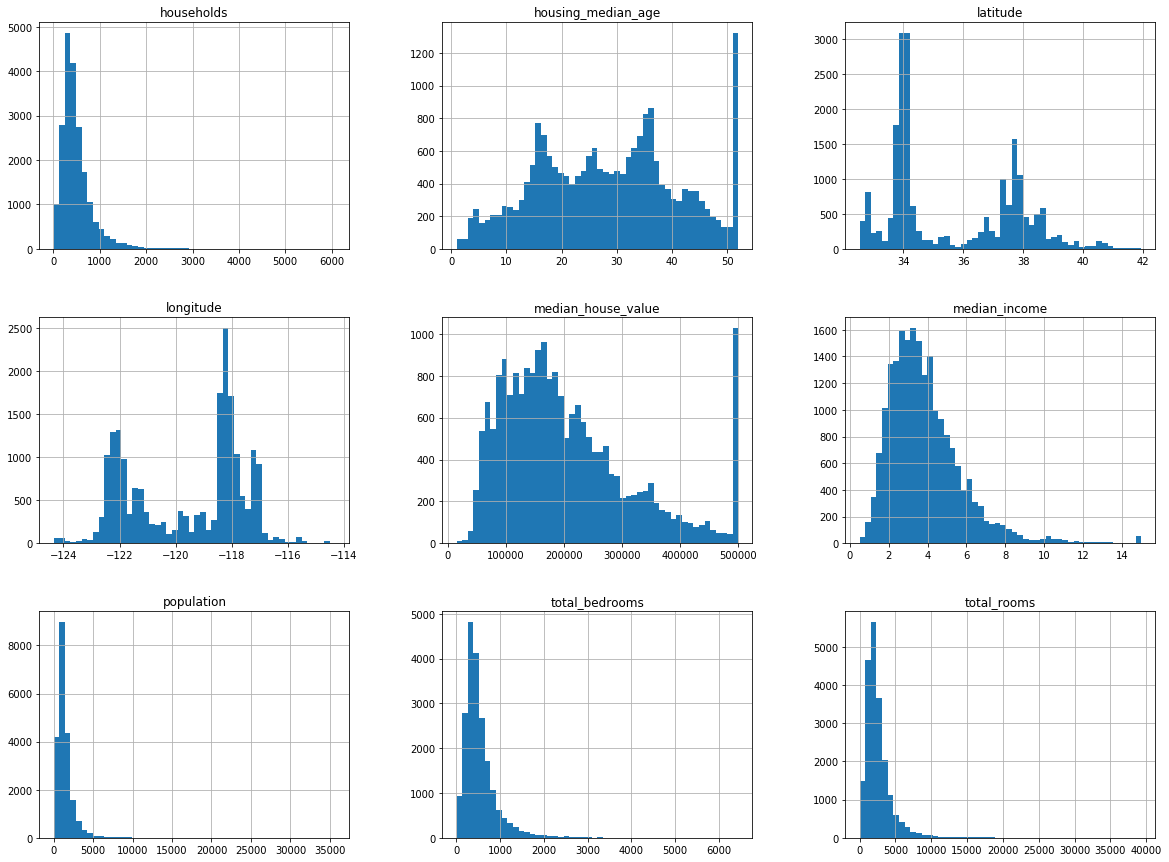

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15));

Few things to note about the histograms.

The median income feature is not expressed in $, it is cleary capped at 15, so we are working we a preprocessed attribute and its important to know how these are computed. 

Housing_median_age and median_house_vale are also capped. Median_house_value is the target feature so this is important and a potential problem. 

Most attributes have DIFFERENT SCALES (discussed later in Feature Scaling)

Many of the histograms are tail heavy (i.e. extend much farther to the right than the left. This could cause problems for some ML algorithms when detecting patterns. A possible solution is to transform the attributes so they have a more bell-shaped distribution. 

#### Create a test set

Scikit-learn provides a few functions to split datasets into TRAIN and TEST. The simplest is the train_test_split function from the model_selection module.

This is a random sampling method, which is generally fine if your dataset is large enough (especially relative to the number of attributes), but if it is not there is the risk of introducing a significant sample bias.

In [7]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

Experts have told you that the median income is a very important attribute to predict median house prices.

Want to ensure that the test set is representitive of the various categories of incomes in the whole dataset.

The median income is a continuous numerical attribute. Lets look at the histogram.

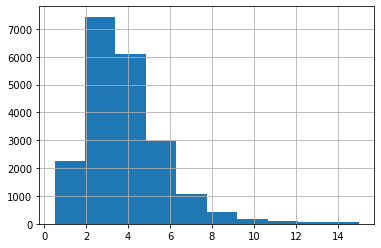

In [8]:
housing["median_income"].hist();

Most median incomes are clustered around 2-5 (10k$). It is important to have a sufficient number of instances in the test dataset for each category/stratum. 

Need to create a new feature that stratifies the median income.

In [9]:
import numpy as np

housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [10]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [11]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1.0,0.039826,0.039729,0.040213,0.973236,-0.243309
2.0,0.318847,0.318798,0.324370,1.732260,-0.015195
3.0,0.350581,0.350533,0.358527,2.266446,-0.013820
4.0,0.176308,0.176357,0.167393,-5.056334,0.027480
5.0,0.114438,0.114583,0.109496,-4.318374,0.127011


We can see that the test set income category proportions compared to the overall dataset is much more aligned with stratified sampling compared to random sampling.

Can now drop the income_cat feature as we don't need it.

In [12]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

#### Visualising Geographical Data

As there is latitude and longitude data in our dataset, it is a good idea to create a scatterplot of all districts to visualise the data.

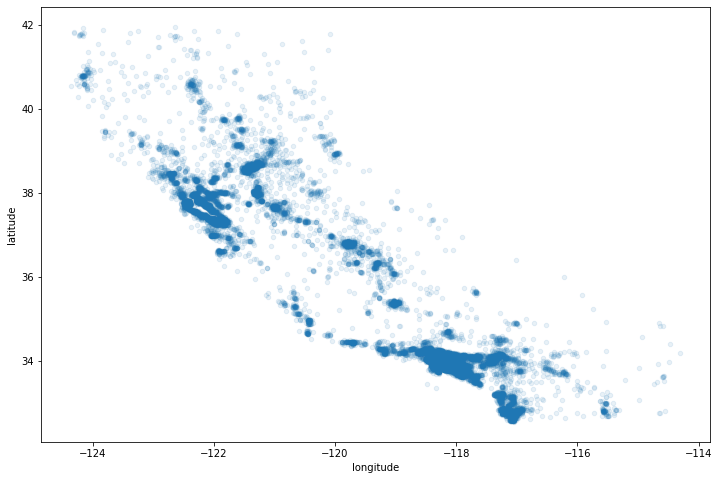

In [13]:
#first copy the strat_train_set to housing so we can work with that
housing = strat_train_set.copy()

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, figsize=(12,8));

Here it is easy to see the density of housing in California. 

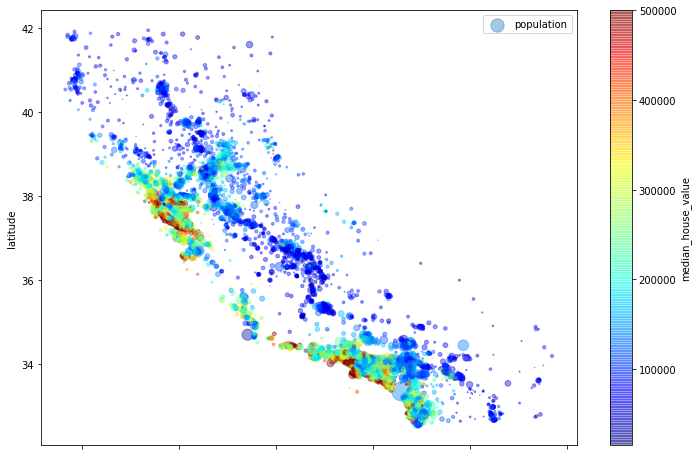

In [14]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing["population"]/100, label="population",
            c="median_house_value", 
            cmap=plt.get_cmap("jet"), colorbar=True, figsize=(12,8))
plt.legend();

From this scatterplot it is clear the housing prices closer the ocean are averagely more expensive. The ocean proximity feature and population density could be important features.

#### Correlations

Can access the standard correlation coefficient (Pearson's r) between every pair using the corr() method.

In [15]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

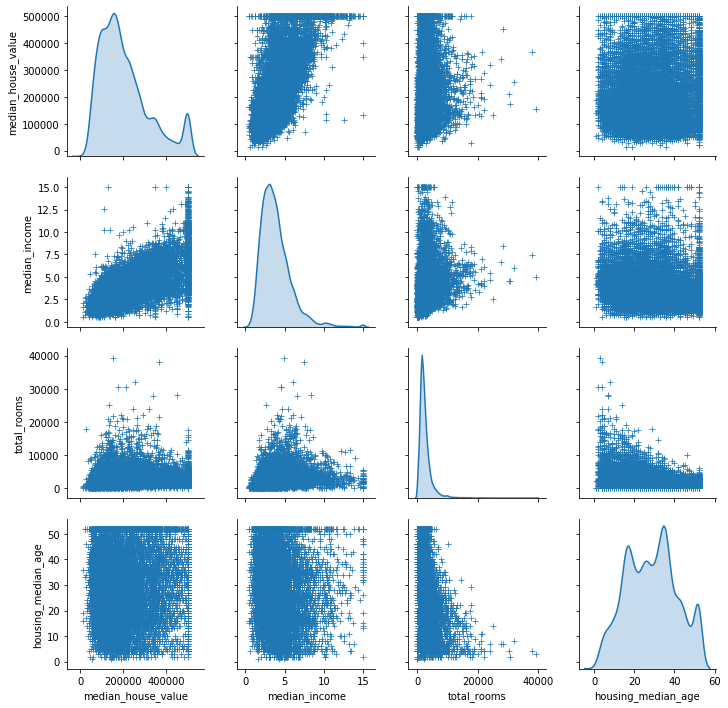

In [16]:
%matplotlib inline
import seaborn as sns
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
g = sns.pairplot(housing, vars=attributes, palette="pastel", dropna=True, diag_kind="kde", markers="+")

The median income is the most correlated value with median house value.

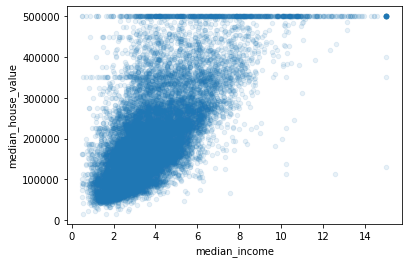

In [17]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1);

Visually there is a clear positive trend. There is a obvious price cap at 500,000, as shown by the line. There are also lines at 450,000 and 350,000. It is worth considering removing the corresponding districts so that the ML algorithm doesn't reproduce the data quirks.

#### Feature Engineering 

Sometimes you can try various attribute combinations. We can see that the total number of bedrooms attribute is not very useful from the correlations. Which makes sense when you consider that it is the total number of bedrooms in a district. What might be of interest is the number of rooms PER household and along the same lines, population per household.

In [18]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [19]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

Can see the bedrooms_per_room is much more correlated with the median house value than the total number. Houses with a lower bedroom/room ratio tend to be more expensive.

### Preparing the Data

Should always write function to prepare the data for machine learning as it will allow you to reproduce the transformation easily on any dataset. You can build your own library of transformations. You can use the functions in the live system to transform the new data before feeding it to the alorithm.

In [20]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

#### Dealing with missing values

The total_bedrooms attribute has some missing values. There are three options to deal with this.

- Get rid of the corresponding districts
- Get rid of the whole attribute
- Set the values to some value (0, mean, median, etc.)

Quite often, option 3 is chosen. If chosen, the mdeian value on the training set should be computed and used to fill the missing values in the training set, but dont forget to save the median value. This will be needed later to replace the missing values in the test set when evaluating the model.

Scikit-learn, as always, provides a class to take care of missing values: Imputer. Make an instance of Imputer and specify the value replacing the missing values.

In [21]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

The median can only be computed on numerical features, so make a copy of the data with the text feature:

In [22]:
housing_num = housing.drop("ocean_proximity", axis=1)

Now you can fit the imputer to the training data with the fit() method.

In [23]:
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

The median values calculated by the imputer are stored in its statistics_ variable:

In [24]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [25]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Finally, the trained imputer is used to transform the training set, resulting in a plain Numpy array of the transformed features. Can be put back into dataframe if needed.

In [26]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

Now we need to deal with the categorical attribute ocean_proximity. As it is text, need to convert to numbers. Scikit-learn provides a transformer for this task called LabelEncoder:

In [27]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

The result is an array of numbers that correspond to the different categories of ocean proximity.

In [28]:
encoder.classes_

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

There is an issue with this representation!

An ML algorithm will assume that two nearby values are more similar than distant ones. To fix this you can create one binary attribute per category. This is called one-hot encoding and again Scikit-Learn provides a Class for it.

An important note thought is that OneHotEncoder expects a 2D array.

In [29]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

The resulting array is acheived through two steps. Both transformations can be done in one, using the LabelBinarizer class:

In [30]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

### Custom Transformers

Sometimes you will need to write your own transformer for data cleaning or combining specific attributes. Like Scikit-learn you will need your function/pipeline to implement three methods:

- fit(): returning self
- transform()
- fit_transform()

Can get fit_transform() by adding TransformerMixin as a base class. Also, by adding BaseEstimator as a base class you will get two extra method (get_params() and set_params()) that will be useful for automatic hyperparameter turning.

An example using the data preparation discussed above:

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_idx, bedrooms_idx, population_idx, household_idx = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_idx] / X[:, household_idx]
        population_per_household = X[:, population_idx] / X[:, household_idx]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_idx] / X[:, rooms_idx]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
    
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

### Feature Scaling

This is one of the most important transformations. With few exceptions, ML agorithms don't perform well when the numerical input features have very different scales.

E.g. total number of rooms 6 to 39,320 - median house value 0 to 15

Two common ways to get all attributes to be on the same scale:

1. Normalisation (min-max scaling): Values are scaled so that they end up ranging from 0 to 1. Acheived by subtracting the min value and dividing by the range. Scikit-Learn does this with a transformer called MinMaxScaler

2. Standardisation: Subtract the mean and then divide by the variance so that the resulting distribution has unit variance. It is not bound to a specific range, which maybe a problem for some algorithms (e.g. Neural Netowrks often expect a input value from 0 to 1). Scikit-Learn provides the transformer StandardScaler

#### Transformation Pipelines

Scikit-Learn provides the Pipeline class to help process sequences of transformations.

For example:

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

Pipeline constructor takes a list of name/estimator pairs definig a sequence of steps. All but the last step must be transformers (i.e. must have fit_transform method). Names can be anything you like.

When you call the pipelines fit() method, it calls the fit_transform() method sequentially on all transformers until it reacher the final estimator, for which it calls the fit() method. In this case the last estimator is a StandardScaler, which is a transformer, sot he pipeline has a fit_transform method.

Have a pipeline for numerical values, also need one for the categorical features. Scikit-Learns FeatureUnion class allows you to join pipelines.

In [33]:
from sklearn.pipeline import FeatureUnion

from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

class CustomLabelBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self, sparse_output=False):
        self.sparse_output = sparse_output
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        enc = LabelBinarizer(sparse_output=self.sparse_output)
        return enc.fit_transform(X)

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', CustomLabelBinarizer()),
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [34]:
housing_prepared.shape

(16512, 16)

### Select And Train A Model

This is a regression problem. We are trying to predict a continuous numerical feature. 

The most simple regression ML algorithm is Linear Regression. It is where you fit a line (vector of predictions) to the data that minimises some cost function.

In [35]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

The Linear Regression model is now fitted to the data. We can evaluate how accurate it is using the RMSE.

In [36]:
from sklearn.metrics import mean_squared_error

housing_prediction = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_prediction)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

This is not a good score. Most districts' median hous values range between 120,000 and 265,000. So a typical prediction error of 68,628 is not good. 

This is an example of a model underfitting the training data. It can mean that the features do not provide enough information to make good predictions, or that the model is simple not powerful enough.

Lets try a more complex model.

In [37]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

No error at all is very dubious! Is it perfect? More likley that the model overfits the data.

Don't want to touch the test set until ready to launch, so can use part of the training set for training and part for model validation.

### Cross-Validation

Can evaulate the Decision Tree model by using the Scikit-Learns cross validation feature.

The following example performs a K-fold cross-validation: randomly splits the training set into n distinct subsets called folds, then it trains and evaluates the model n times. The result is an array containing n evaluation scores. 

n is called cv in the function:

In [38]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print(f"Scores: {scores}")
    print(f"Mean: {scores.mean()}")
    print(f"Std Dev: {scores.std()}")

display_scores(rmse_scores)

Scores: [68368.26593767 66284.74853649 70182.39112412 68697.36863828
 70933.70977097 74108.4787234  71438.17859207 71666.56722932
 76745.7859209  70193.95828482]
Mean: 70861.94527580545
Std Dev: 2809.034188925585


Now the decision tree doesn't look as good as it did earlier! In fact, on average, it performs worse than the Linear Regression model. 

Lets do the same for the LinReg model:

In [39]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

display_scores(rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Std Dev: 2731.6740017983466


Decision Tree model is overfitting so badly that it performs worse!

Try one last model: Random Forest - Bunch of decision trees

In [40]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21941.911027380233

In [41]:
scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

display_scores(rmse_scores)

Scores: [51650.94405471 48920.80645498 52979.16096752 54412.74042021
 50861.29381163 56488.55699727 51866.90120786 49752.24599537
 55399.50713191 53309.74548294]
Mean: 52564.19025244012
Std Dev: 2301.873803919754


Random Forest seems to be the most promising model. However, it can be seen that the score for the whole training set is better than for the cross-validation K-folds, therefore indicative of overfitting.

Possible solutions are to simplify the model (i.e. regularize it) or get a lot more training data.

You should save every model you experiment with, so you can come back easily. This can be done with Python's pickle module, or using sklearn.externals.joblib, which is more efficient at serializing NumPy arrays.

### Fine Tune The Model

#### Grid Search

Hyperparamters are values that are set at the beginning to the learning process. They are specific to each ML algorithm. It is best to find the best combination of hyperparamters for your ML model.

One way to do this is to use Scikit-Learns GridSearchCV.

An example with the random forest model:

In [42]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring="neg_mean_squared_error")

grid_search.fit(housing_prepared, housing_labels)
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [43]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [44]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

65067.93750644376 {'max_features': 2, 'n_estimators': 3}
55605.83056655676 {'max_features': 2, 'n_estimators': 10}
52882.85427219134 {'max_features': 2, 'n_estimators': 30}
60005.67307265607 {'max_features': 4, 'n_estimators': 3}
52914.57939381306 {'max_features': 4, 'n_estimators': 10}
50444.644206726 {'max_features': 4, 'n_estimators': 30}
60099.52492795187 {'max_features': 6, 'n_estimators': 3}
52127.92386515065 {'max_features': 6, 'n_estimators': 10}
50011.702656853144 {'max_features': 6, 'n_estimators': 30}
58867.503437203304 {'max_features': 8, 'n_estimators': 3}
51852.79657350121 {'max_features': 8, 'n_estimators': 10}
49983.12184608706 {'max_features': 8, 'n_estimators': 30}
62279.73509575333 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53850.79936329791 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60743.50679725481 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52699.57658834583 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10

Grid approach is great when exploring relatively few combinations, but when the hyperparamteter search space is large, it is often preferable to use a Randomised Search V instead.

#### Ensemble Methods

Another way to fine-tune your system is to try to combine the models that perform best - ensemble learning!

For example Random forest is an ensemble of decision trees.

### Analyse Best Models and Their Errors

Often gain good insights on the problem by inspecting the best models. For example, the RandomForestRegressor can indicate the relative importance of each feature for making accurate predictions:

In [45]:
feature_importances = grid_search.best_estimator_.feature_importances_

extra = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
one_hot = list(encoder.classes_)
features = num_attribs + extra + one_hot
sorted(zip(feature_importances, features), reverse=True)

[(0.3816000838621611, 'median_income'),
 (0.1599364846931526, 'INLAND'),
 (0.11176526595157359, 'pop_per_hhold'),
 (0.06905983808517605, 'longitude'),
 (0.05778679366322313, 'latitude'),
 (0.053967735155788496, 'rooms_per_hhold'),
 (0.04942910119601713, 'bedrooms_per_room'),
 (0.04364719594660138, 'housing_median_age'),
 (0.016051135557613082, 'total_rooms'),
 (0.015452675076191925, 'total_bedrooms'),
 (0.014545752234427556, 'households'),
 (0.014409517866589883, 'population'),
 (0.007293252644351536, '<1H OCEAN'),
 (0.0027692935056648107, 'NEAR OCEAN'),
 (0.0022175164049742916, 'NEAR BAY'),
 (6.835815649347723e-05, 'ISLAND')]

With this info you can consider dropping the less useful features.

### Evaluate Model on Test Set

Now we have our best model and best hyperparamters, its time to run on the test set.

In [46]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47938.30245849253

## Launch,